In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
data_dir = '/home/ethan/work/projects/mammalian_motor_cortex_comparative/fig2/data/outputs/gex_de_results/lrt/aggregate'
data2_dir = '/home/ethan/work/projects/mammalian_motor_cortex_comparative/03_atac/data/outputs/atac_de_results/human_origin/lrt/aggregate'

def read_list(listfile):

    return open(listfile, 'r').read().strip('\n').split('\n')

tf_names = read_list('tf_gene_names.txt')

div_gex = pd.read_csv(data_dir +'/human_v_all_logfc.tsv', sep='\t').set_index('Unnamed: 0')
order_use = div_gex.columns
div_atac = pd.read_csv(data2_dir +'/human_v_mouse_logfc.tsv', sep='\t').set_index('Unnamed: 0')[order_use]

In [4]:
atac_acces = pd.read_csv('/home/ethan/work/projects/mammalian_motor_cortex_comparative/03_atac/data/processed/atac_for_gls/human_origin_peaks/log2cpm/human_clusters_orthologous_counts.txt',sep='\t').set_index('human')[order_use]

In [5]:
gene_expr = pd.read_csv('/home/ethan/work/projects/mammalian_motor_cortex_comparative/fig2/data/processed/gex_for_gls/log2cpm/human_clusters_orthologous_counts.txt',
                    sep='\t').set_index('human_gene')[order_use]

In [6]:
atac_acces = np.exp2(atac_acces) - 1

In [7]:
gene_expr = np.exp2(gene_expr) - 1

In [8]:
atac_cons = pd.read_csv('/home/ethan/work/projects/mammalian_motor_cortex_comparative/fig2/data/outputs/atac_levels/atac_summary_table.tsv', sep='\t')
atac_cons = atac_cons.loc[atac_cons.mammal_level0]
atac_summary = atac_cons.copy()
atac_cons = atac_cons[['shortname', '0', '1', '2', '3', 'conservation_idx', 'conservation_idx_primate']]

distal_peaks = atac_summary.loc[(atac_summary.nearest_tss_dist.abs() > 1000) & (atac_summary.mammal_level0), ['shortname', '3']]

In [9]:
atac_acces = atac_acces.loc[atac_acces.index.isin(distal_peaks.shortname) & atac_acces.index.isin(div_atac.index)]

In [10]:
peak_calls = pd.read_csv('data/human_union_peak_calls.tsv', sep='\t').set_index('3')
peak_calls = peak_calls.loc[peak_calls.index.isin(atac_summary['3'])]
peak_calls['shortname'] = atac_summary.set_index('3').loc[peak_calls.index, 'shortname']
peak_calls = peak_calls.set_index('shortname')
peak_calls = peak_calls.loc[peak_calls.index.isin(distal_peaks['shortname'])]

In [11]:
peak_calls = peak_calls.reindex(atac_acces.index)[atac_acces.columns]

In [12]:
# set non_peaks to zero
atac_acces = atac_acces * peak_calls

In [13]:
atac_acces = (atac_acces * 1e6)/atac_acces.sum()

In [14]:
colors = """ASC	#6FF17D
ChC	#004EE3
Endo	#60C200
L2_3_IT	#FF6FEB
L4_5_IT	#F15A98
L5_ET	#EE7E94
L5_IT	#FA9E8B
L5_6_NP	#F24799
L6_CT	#EB9863
L6_IT	#EAACD3
L6_IT_CAR3	#FF7F00
L6b	#FFAC3B
LAMP5	#3E9DDF
MGC	#70AD47
ODC	#ACF068
OPC	#C3D740
PVALB	#87B9DD
SNCG	#6167E1
SST	#684CE3
VIP	#9000E3
VLMC	#9CBC00"""
colors = colors.split('\n')
colors = {i.split('\t')[0] : i.split('\t')[1] for i in colors}

# the above is all kosher

In [15]:
expr_ct = (gene_expr.loc[~gene_expr.index.isin(tf_names)]*1e6)/gene_expr.loc[~gene_expr.index.isin(tf_names)].mean()
expr_tf = (gene_expr.loc[gene_expr.index.isin(tf_names)]*1e6)/gene_expr.loc[gene_expr.index.isin(tf_names)].mean()

expr_div_tf = (div_gex.loc[div_gex.index.isin(tf_names)] * expr_tf).abs().mean()
expr_div_ct = (div_gex.loc[~div_gex.index.isin(tf_names)] * expr_ct).abs().mean()

In [16]:
div_atac_ct = (div_atac * atac_acces).abs().mean()

Text(0, 0.5, 'mean expression div')

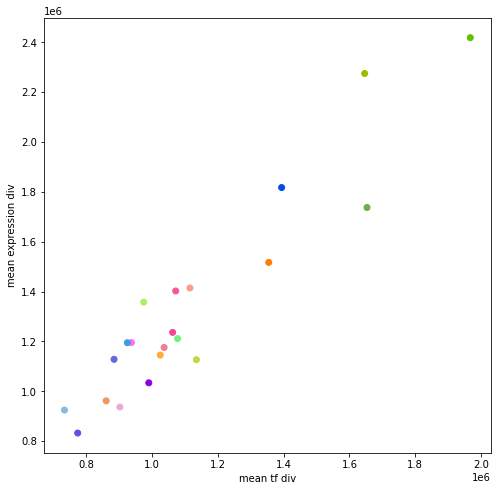

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(expr_div_tf,
            expr_div_ct, c=[colors[i] for i in  expr_div_ct.index])
plt.xlabel('mean tf div')
plt.ylabel('mean expression div')

In [18]:
atac_cons = atac_cons.set_index('shortname')
atac_cons_ct = (atac_acces.T * atac_cons['conservation_idx'].T).mean(axis=1)

In [19]:
from scipy.stats import spearmanr, pearsonr

Text(0, 0.5, 'weighted atac divergence')

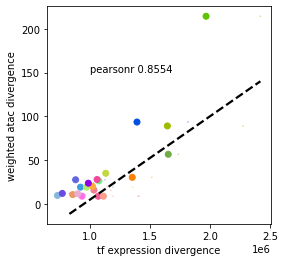

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.regplot(x=expr_div_ct,
            y=div_atac_ct,
            # c=[colors[i] for i in  k27_ct]
            line_kws={'ls' : '--', 'color': 'black'},
            scatter_kws={'color' : [colors[i] for i in  div_atac_ct.index], 's':.1},
            ci=None
           )
plt.scatter(expr_div_tf,
            div_atac_ct,
            c=[colors[i] for i in  expr_div_ct.index])
plt.text(1e6,  150, 'pearsonr {:.4}'.format(pearsonr(expr_div_tf,
                                                      div_atac_ct)[0]))
plt.xlabel('tf expression divergence')
plt.ylabel('weighted atac divergence')
# plt.savefig("figures/cell_type_tf_divergence_v_atac_divergence_pearson.pdf", transparent=True, dpi=400)

In [21]:
pearsonr(expr_div_tf,
            div_atac_ct)

(0.8553999340163494, 7.747006488998512e-07)

In [23]:
# tf div vs atac_dif, p= 7.747 e-7
# atac_cons vs phastcons_motif, p = 0.00221

In [23]:
# get phastcons
peak_phastcons = pd.read_csv('data/average_phastcons_level0_peaks.tsv', sep ='\t', header=None).set_index(0)
peak_phastcons = peak_phastcons.join(atac_cons.reset_index().set_index('3')['shortname'])
peak_phastcons = peak_phastcons.reset_index().set_index('shortname')
ct_phastcons = (atac_acces.T * peak_phastcons[1].T).mean(axis=1)

In [24]:
# get phastcons
motif_phastcons = pd.read_csv('data/average_phastcons_motifs_in_each_peak.tsv', sep ='\t', header=None).set_index(0)
motif_phastcons
motif_phastcons = motif_phastcons.join(atac_cons.reset_index().set_index('3')['shortname'])
motif_phastcons = motif_phastcons.dropna(axis=0)

motif_phastcons = motif_phastcons.reset_index().set_index('shortname')
ct_phastcons_motif = (atac_acces.T * motif_phastcons[1].T).mean(axis=1)

In [45]:
spearmanr(ct_phastcons_motif,
            atac_cons_ct,)

SpearmanrResult(correlation=0.6467532467532467, pvalue=0.0015327687890187203)

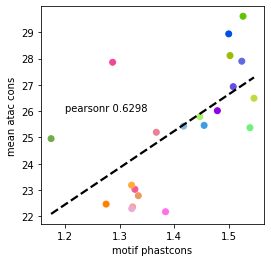

In [50]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.regplot(x=ct_phastcons_motif,
            y=atac_cons_ct,
            # c=[colors[i] for i in  k27_ct]
            line_kws={'ls' : '--', 'color': 'black'},
            scatter_kws={'s':.1,
                'color' : [colors[i] for i in  div_atac_ct.index]},
            ci=None
           )
plt.scatter(x=ct_phastcons_motif,
            y=atac_cons_ct,
            c=[colors[i] for i in  expr_div_ct.index])

plt.text(1.2,  26, 'pearsonr {:.4}'.format(pearsonr(atac_cons_ct,
                                                      ct_phastcons_motif)[0]))
plt.xlabel('motif phastcons')
plt.ylabel('mean atac cons')
# ax.plot(np.linspace(.4, 2.25, 10), np.linspace(.4, 2.25, 10), '--', c='black')
plt.savefig("figures/cell_type_atac_cons_v_phastcons.pdf", transparent=True, dpi=400)
# ax.plot(np.linspace(.4, 2.25, 10), np.linspace(.4, 2.25, 10), '--', c='black')

In [49]:
pearsonr(atac_cons_ct, ct_phastcons_motif), spearmanr(atac_cons_ct, ct_phastcons_motif)

((0.6297920167867516, 0.0022166413515756554),
 SpearmanrResult(correlation=0.6467532467532467, pvalue=0.0015327687890187203))